<a href="https://colab.research.google.com/github/BDouchet/BMDATA/blob/main/TPEmotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read data

Dataset is composed of two parts :

*   Landmarks extracted from face images (mixture of CK+ and JAFFE datasets). It consists of a distances between 68 landmarks and then flatten to get a vector of length : 68 * 68 = 4624. The number of training data is 741. The output is a sentiment one-hot encoded between 7 classes.

*   48x48 gray-scale images of faces from FER2013 Dataset. The output is the same : one-hot encoding of the sentiment between 7 available classes. The number of available training data is 19357.

The aim is to detect the sentiment expressed on a face. 

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1Lrkyg-gt0UzdmLvpcYtSFErXFOTGBx__'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data.zip')

with ZipFile('data.zip', 'r') as zip:
   zip.extractall()
   print('Done')


Done


# Landmarks 

Read and process the landmarks. 

In [ ]:
x_train=np.load('/content/train_test_landmarks/x_train.npy')
x_test=np.load('/content/train_test_landmarks/x_test.npy')
y_train=np.load('/content/train_test_landmarks/y_train.npy')
y_test=np.load('/content/train_test_landmarks/y_test.npy')

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(741, 4624) (741, 7) (365, 4624) (365, 7)


Create the model.

In [ ]:
model=models.Sequential()
model.add(layers.Dense(512,input_shape=(68*68,),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               2368000   
_________________________________________________________________
batch_normalization_181 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_151 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_182 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_152 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)              

Training of the model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.0001),metrics=['acc'])
history=model.fit(x_train,y_train,epochs=50,batch_size=16,verbose=2,validation_data=(x_test,y_test))

Epoch 1/50
47/47 - 0s - loss: 2.2236 - acc: 0.3009 - val_loss: 1.8878 - val_acc: 0.2356
Epoch 2/50
47/47 - 0s - loss: 1.6068 - acc: 0.4885 - val_loss: 1.5020 - val_acc: 0.6000
Epoch 3/50
47/47 - 0s - loss: 1.4527 - acc: 0.5587 - val_loss: 1.2991 - val_acc: 0.6219
Epoch 4/50
47/47 - 0s - loss: 1.2698 - acc: 0.5978 - val_loss: 0.8214 - val_acc: 0.7479
Epoch 5/50
47/47 - 0s - loss: 1.1389 - acc: 0.6397 - val_loss: 0.7505 - val_acc: 0.7644
Epoch 6/50
47/47 - 0s - loss: 1.1286 - acc: 0.6545 - val_loss: 0.7743 - val_acc: 0.7479
Epoch 7/50
47/47 - 0s - loss: 1.0520 - acc: 0.6883 - val_loss: 0.8174 - val_acc: 0.7425
Epoch 8/50
47/47 - 0s - loss: 0.9940 - acc: 0.6815 - val_loss: 1.1558 - val_acc: 0.6630
Epoch 9/50
47/47 - 0s - loss: 0.9777 - acc: 0.7018 - val_loss: 0.8933 - val_acc: 0.7479
Epoch 10/50
47/47 - 0s - loss: 0.9625 - acc: 0.7126 - val_loss: 1.3147 - val_acc: 0.5973
Epoch 11/50
47/47 - 0s - loss: 1.0172 - acc: 0.6964 - val_loss: 1.0273 - val_acc: 0.7041
Epoch 12/50
47/47 - 0s - loss:

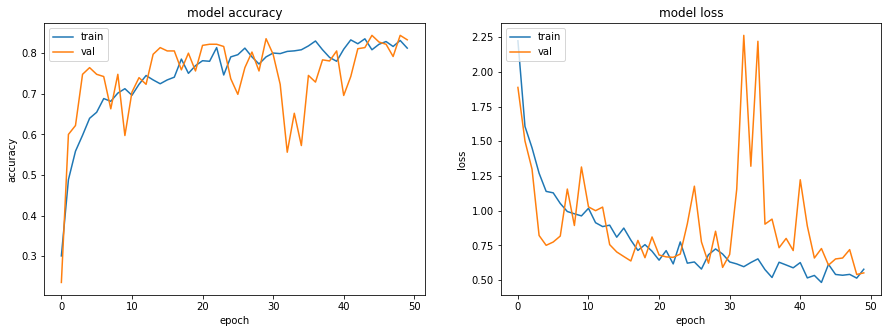

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

Code Snippet to take a picture from the webcam.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

cap = take_photo()



<IPython.core.display.Javascript object>

Application of the trained model to real images. First, I detect the face, then I landmark it and calculate the distances. Finally I predict the sentiment of the photo.

rectangles[[(291, 192) (513, 415)]]
[0.         0.12509996 0.255196   ... 0.09513149 0.05024938 0.        ]
[[0.64039934 0.29022864 0.00289404 0.00581146 0.01811596 0.00295477
  0.0395958 ]]


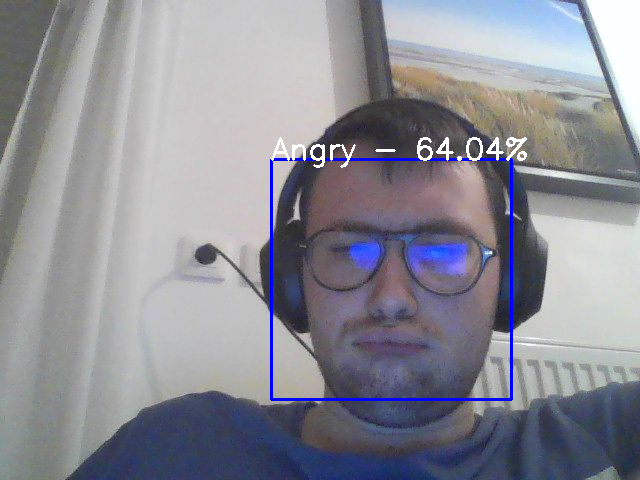

In [ ]:
import numpy as np
import cv2
from imutils import face_utils
import imutils
import dlib
import math
from sklearn.preprocessing import MinMaxScaler

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def euclidean_all(a):
    distances = []
    for i in range(len(a)):
        for j in range(len(a)):
            distances.append(cv2.norm((int(a[i][0]), int(a[i][1])),(int(a[j][0]), int(a[j][1])),cv2.NORM_L2))
    return np.array(distances)

def detect_parts(image):
    # resize the image, and convert it to grayscale
    image = imutils.resize(image, width=200, height=200)
    # detect faces in the grayscale image
    rects = detector(gray,1)
    print(rects)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        distances = euclidean_all(shape)/200
    return distances

img=cv2.imread('photo.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray , 1.3, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    detected_face = img[int(y):int(y + h), int(x):int(x + w)]
    distances = detect_parts(detected_face)
    print(distances)
    predictions = model.predict(np.array([distances]))
    print(predictions)
    index=np.argmax(predictions[0])
    emotion=emotions[index]
    cv2.putText(img,emotion + " - "+str("{0:.2%}".format(predictions[0][index])), 
                (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2_imshow(img)


# SAME WITH CNN

Read and proces data

In [ ]:
X_test=np.load('/content/train_test_faceImages/images_test.npy')
X_train=np.load('/content/train_test_faceImages/images_train.npy')
Y_test=np.load('/content/train_test_faceImages/labels_test.npy')
Y_train=np.load('/content/train_test_faceImages/labels_train.npy')

print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(19357, 48, 48, 1) (19357, 7) (2151, 48, 48, 1) (2151, 7)


Creation of our network. 

I tried a lot of architectures and it was always hardly fitting the dataset. I tried this one as the least worst of my attempts. This is mainly because of the low quality of the input : the images are gary-scaled and small (48x48). The quantity of useful data on each image is very small and only localised at the center of the face. So only a small portion of the image allows to understand the sentiment and even human are not as performant for this task.

*Attempts : ResNet, VGG, ASPP, Dropout, activation, different classifier, more or less weight layers, learning rate, optimizer...*

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_167 (Bat (None, 46, 46, 32)        128       
_________________________________________________________________
dropout_137 (Dropout)        (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 22, 22, 32)        16416     
_________________________________________________________________
batch_normalization_168 (Bat (None, 22, 22, 32)        128       
_________________________________________________________________
dropout_138 (Dropout)        (None, 22, 22, 32)      

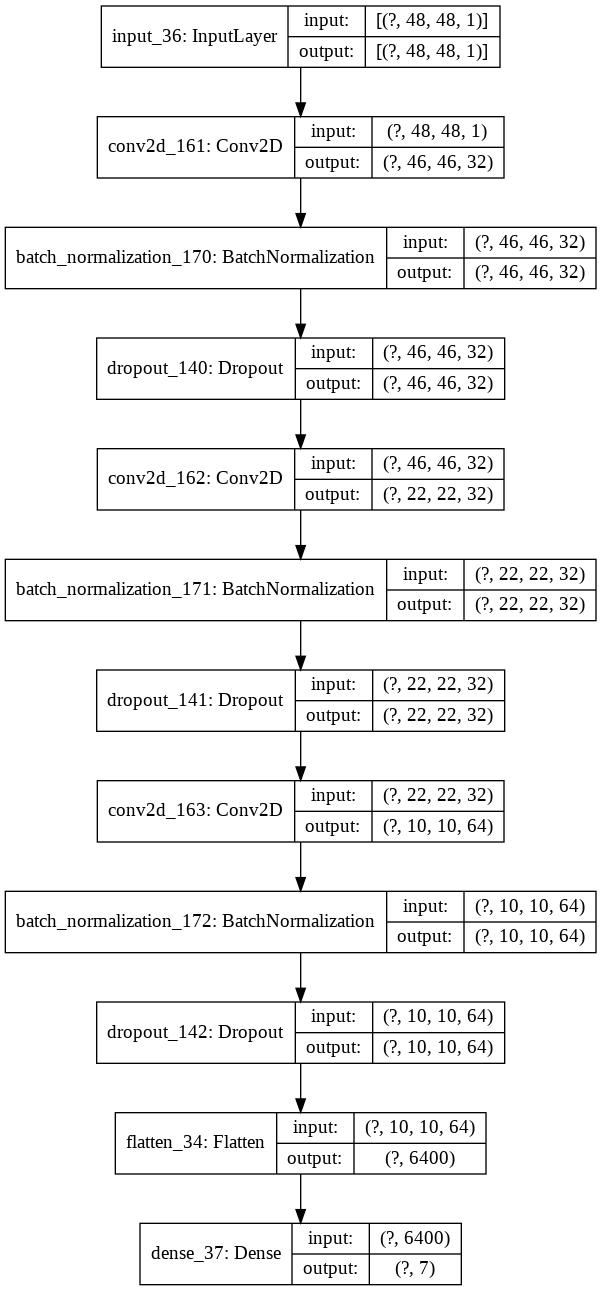

In [ ]:
def Network():
    input=layers.Input(shape=(48,48,1))

    x = layers.Conv2D(32,3,padding='valid',activation='sigmoid')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(32,4,padding='valid',activation='sigmoid', strides=(2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    x = layers.Conv2D(64,4,padding='valid',activation='sigmoid', strides=(2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    
    x = layers.Flatten()(x)
    output = layers.Dense(7,activation='softmax')(x)
    return models.Model(input,output)

print(Network().summary())
tf.keras.utils.plot_model(Network(),show_shapes=True)

I also added vertical flip to performan data augmentation. The data are also shuffled to decraese the overfitting.

In [ ]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)

modelCNN=Network()
modelCNN.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(),metrics=['acc'])
historyCNN=modelCNN.fit(datagen.flow(X_train, Y_train, batch_size=32,shuffle=True),
                        epochs=50,steps_per_epoch=len(X_train) / 32,
                        verbose=1,validation_data=(X_test,Y_test))

Epoch 1/50
605/604 [==============================] - 4s 6ms/step - loss: 2.3296 - acc: 0.2998 - val_loss: 1.7202 - val_acc: 0.3891
Epoch 2/50
605/604 [==============================] - 3s 6ms/step - loss: 1.8133 - acc: 0.3707 - val_loss: 1.6307 - val_acc: 0.4170
Epoch 3/50
605/604 [==============================] - 3s 5ms/step - loss: 1.5670 - acc: 0.4208 - val_loss: 1.4444 - val_acc: 0.4668
Epoch 4/50
605/604 [==============================] - 3s 6ms/step - loss: 1.4441 - acc: 0.4623 - val_loss: 1.5035 - val_acc: 0.4482
Epoch 5/50
605/604 [==============================] - 3s 6ms/step - loss: 1.3826 - acc: 0.4839 - val_loss: 1.4523 - val_acc: 0.4598
Epoch 6/50
605/604 [==============================] - 3s 6ms/step - loss: 1.3298 - acc: 0.5051 - val_loss: 1.3167 - val_acc: 0.5114
Epoch 7/50
605/604 [==============================] - 3s 5ms/step - loss: 1.2807 - acc: 0.5257 - val_loss: 1.3731 - val_acc: 0.4733
Epoch 8/50
605/604 [==============================] - 3s 5ms/step - loss: 1.

A not-so-bad model.

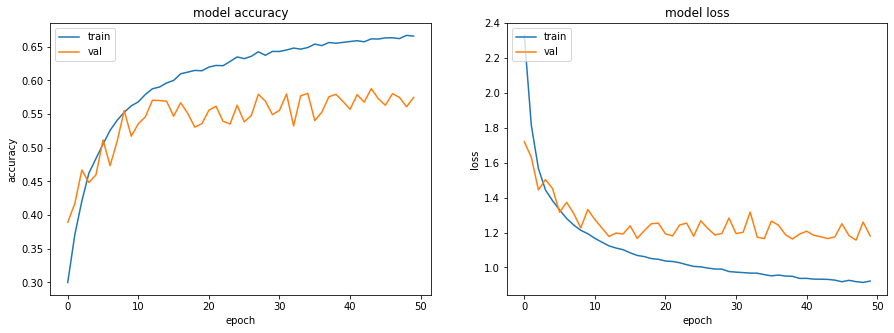

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(historyCNN.history['acc'])
ax1.plot(historyCNN.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(historyCNN.history['loss'])
ax2.plot(historyCNN.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

View of the prediction.

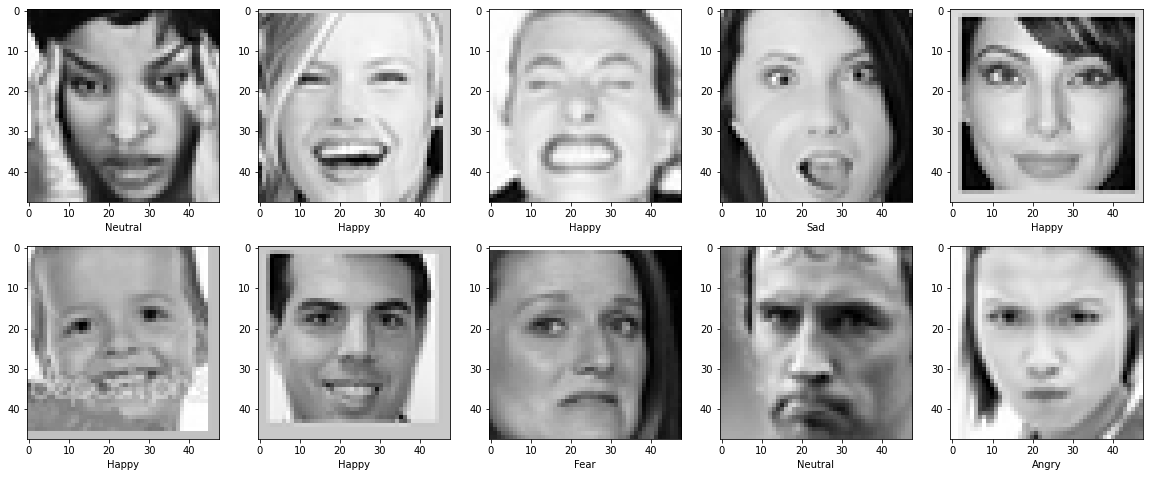

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

Y_pred=modelCNN.predict(X_test[:10])
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_test[i,:,:,0],cmap='gray')
    ax.set_xlabel(emotions[np.argmax(Y_test[i])])
plt.show()

Try on real images convert to Black and white.

[1.1680614e-02 7.3231297e-04 4.8432627e-01 1.2762420e-05 1.6486095e-04
 5.0292897e-01 1.5418079e-04]


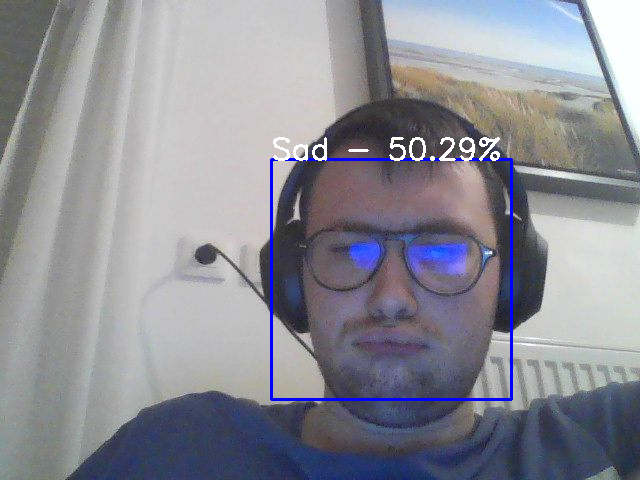

In [ ]:
img=cv2.imread('photo.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray , 1.3, 5)
for (x, y, w, h) in faces:

    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2) 
    detected_face = gray[int(y):int(y + h), int(x):int(x + w)] 
    detected_face = cv2.resize(detected_face,(48,48))
    detected_face=np.reshape(detected_face,(48,48,1))

    predictions = modelCNN.predict(np.array([detected_face]))[0]
    print(predictions) 

    index=np.argmax(predictions)
    emotion=emotions[index]
    cv2.putText(img,emotion + " - "+str("{0:.2%}".format(predictions[index])), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
cv2_imshow(img)